In [0]:
import math
import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

!pip install -q minisom
from minisom import MiniSom

In [0]:
def load_sample(dset, n_classes, method):
  
  url = 'drive/My Drive/Diplomamunka/training data/'

  # Load files
  spects = np.load(url+'spectrograms_'+dset+'_'+str(n_classes)+'_'+method+'.npy')
  labels = np.load(url+'labels_'+dset+'_'+str(n_classes)+'.npy')
  labels = np.argmax(labels, axis=1)
  
  # Distribution of labels
  print("Label distribution:", np.histogram(labels, bins=np.unique(labels)),'\nTotal:', len(labels))
  #print("Nr of spectrograms:", len(spects))

  # Sample k elements from each class
  k = 150
  spects_sampled = []
  labels_sampled = []
  np.random.seed(0)

  for label in np.unique(labels)[:5]:
    idxs = np.squeeze(np.argwhere(labels == label)) 
    idxs = np.random.choice(idxs, size=k)
    #idxs = [np.random.randint(0, len(idxs)) for i in range(k)]

    spects_sampled.append(spects[idxs])
    labels_sampled.append([label for i in range(k)])

  spects_sampled = np.concatenate(spects_sampled, axis=0)
  labels_sampled = np.concatenate(labels_sampled, axis=0)
  '''
  idxs = [np.random.randint(0, len(spects)) for i in range(1000)]
  spects = spects[idxs]
  labels = labels[idxs]
  '''
  print("Spectrogram dataset shape:", spects_sampled.shape)

  # Shuffle
  p = np.random.permutation(len(labels_sampled))
  labels_sampled, spects_sampled = labels_sampled[p], spects_sampled[p]

  return labels_sampled, spects_sampled

In [0]:
def print_stats(labels, features, fe_method, n_classes, reshape_method):

  # General info
  print("Feature extraction method:", fe_method)
  print("Reshaping method:", reshape_method)
  print("Data shape:", features.shape)

  # Clustering metrics for the high dimensional data
  sample_size = 100

  kmeans = KMeans(init='k-means++', n_clusters=n_classes, n_init=10)
  kmeans.fit(features)

  print('Clustering metrics: %.3f %.3f %.3f %.3f %.3f'
            % (
              metrics.homogeneity_score(labels, kmeans.labels_),
              metrics.completeness_score(labels, kmeans.labels_),
              metrics.v_measure_score(labels, kmeans.labels_),
              metrics.silhouette_score(features, kmeans.labels_,
                                    metric='euclidean',
                                    sample_size=sample_size),
              metrics.silhouette_score(features, kmeans.labels_,
                                    metric='cosine',
                                    sample_size=sample_size)
              ))
  '''

  '''
  print("--------------------\n")

In [0]:
def reshape(data, reshape_method, normalize_before, normalize_after):

  # Normalize frequency-wise before reshape
  if normalize_before:
    for i in range(len(data)):
      scaler = StandardScaler()
      data[i] = scaler.fit_transform(data[i].T).T

  # Flatten
  if reshape_method == 1:
    features = data.reshape(len(data), -1)
  
  # Calculate stats over duration of audio segment
  elif reshape_method == 2:
    means = np.mean(data, axis=2)
    stds = np.std(data, axis=2)
    min = np.min(data, axis=2)
    max = np.max(data, axis=2)

    features = np.hstack([means, stds])
    #print(features.shape)

  # Normalize after reshaping
  if normalize_after:
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

  return features

In [0]:
n_classes = 5
methods = ['feat6', 'mfcc30', 'mfcc13', 'mel13', 'log_stft13']
dsets = ['urbansound', 'urbanacoustic', 'esc']

for fe_method in methods[:]:
  for reshape_method in range(1,3):
    
    labels, features = load_sample(dsets[0], n_classes, fe_method)

    features = reshape(features, reshape_method, normalize_before=False, 
                       normalize_after=True)
    
    print_stats(labels, features, fe_method, n_classes, reshape_method)

Label distribution: (array([  622,  8749, 12178, 19810]), array([0, 1, 2, 3, 4])) 
Total: 41359
Spectrogram dataset shape: (750, 6, 44)
Feature extraction method: feat6
Reshaping method: 1
Data shape: (750, 264)
Clustering metrics: 0.049 0.059 0.053 0.222 0.004
--------------------

Label distribution: (array([  622,  8749, 12178, 19810]), array([0, 1, 2, 3, 4])) 
Total: 41359
Spectrogram dataset shape: (750, 6, 44)
Feature extraction method: feat6
Reshaping method: 2
Data shape: (750, 12)
Clustering metrics: 0.068 0.084 0.075 0.218 0.222
--------------------

Label distribution: (array([  622,  8749, 12178, 19810]), array([0, 1, 2, 3, 4])) 
Total: 41359
Spectrogram dataset shape: (750, 30, 44)
Feature extraction method: mfcc30
Reshaping method: 1
Data shape: (750, 1320)
Clustering metrics: 0.109 0.125 0.116 0.013 0.055
--------------------

Label distribution: (array([  622,  8749, 12178, 19810]), array([0, 1, 2, 3, 4])) 
Total: 41359
Spectrogram dataset shape: (750, 30, 44)
Feature e

In [0]:
colors = np.array(['blue', 'red', 'green', 'black', 'yellow'])

def plot_all(results, labels):
  
  # Removing outliers
  def remove_outliers(data):

    mean = np.mean(data, axis=0)
    dists = [np.linalg.norm(x-mean) for x in data]
    dists = sorted(dists)

    Q3 = np.quantile(dists, 0.9)

    idxs = [i for i, x in enumerate(data) if np.linalg.norm(x-mean) < Q3]
    return idxs

  # Plotting
  nrows = math.ceil(len(results)/3)
  fig, axs = plt.subplots(nrows=nrows, 
                          ncols=3, figsize=(20, 6*nrows), squeeze=False)

  id = 0
  for i, row in enumerate(axs):
      for j, col in enumerate(row):
        if id >= len(results):
          break
        
        inlier_idxs = remove_outliers(results[id]['data'])
        #print('Lens', len(labels), len(results[id]['data']), len(inlier_idxs))
        inliers = results[id]['data'][inlier_idxs]
        inlier_labels = labels[inlier_idxs]

        col.scatter(inliers[:,0], 
                    inliers[:,1], 
                    s=3, c=colors[inlier_labels % len(colors)])
        id+=1

plt.show()      

In [0]:
labels, features = load_sample(dsets[0], n_classes, 'mfcc13')

features = reshape(features, reshape_method=2, normalize_before=False, 
                  normalize_after=True)

test_tsne = True
test_isomap = True   
test_pca = True
test_som = True

label_names = ['car_horn', 'dog_bark', 'street_music', 'children_playing', 'engine_idling']
zipp = zip(label_names, colors)
for (x, y) in zipp:
  print(x, '=', y)

Label distribution: (array([  622,  8749, 12178, 19810]), array([0, 1, 2, 3, 4])) 
Total: 41359
Spectrogram dataset shape: (750, 13, 44)
car_horn = blue
dog_bark = red
street_music = green
children_playing = black
engine_idling = yellow


Calculating with parameters: 2 1000
Calculating with parameters: 2 2000
Calculating with parameters: 2 4000
Calculating with parameters: 5 1000
Calculating with parameters: 5 2000
Calculating with parameters: 5 4000
Calculating with parameters: 10 1000
Calculating with parameters: 10 2000
Calculating with parameters: 10 4000
Calculating with parameters: 20 1000
Calculating with parameters: 20 2000
Calculating with parameters: 20 4000
Calculating with parameters: 40 1000
Calculating with parameters: 40 2000
Calculating with parameters: 40 4000


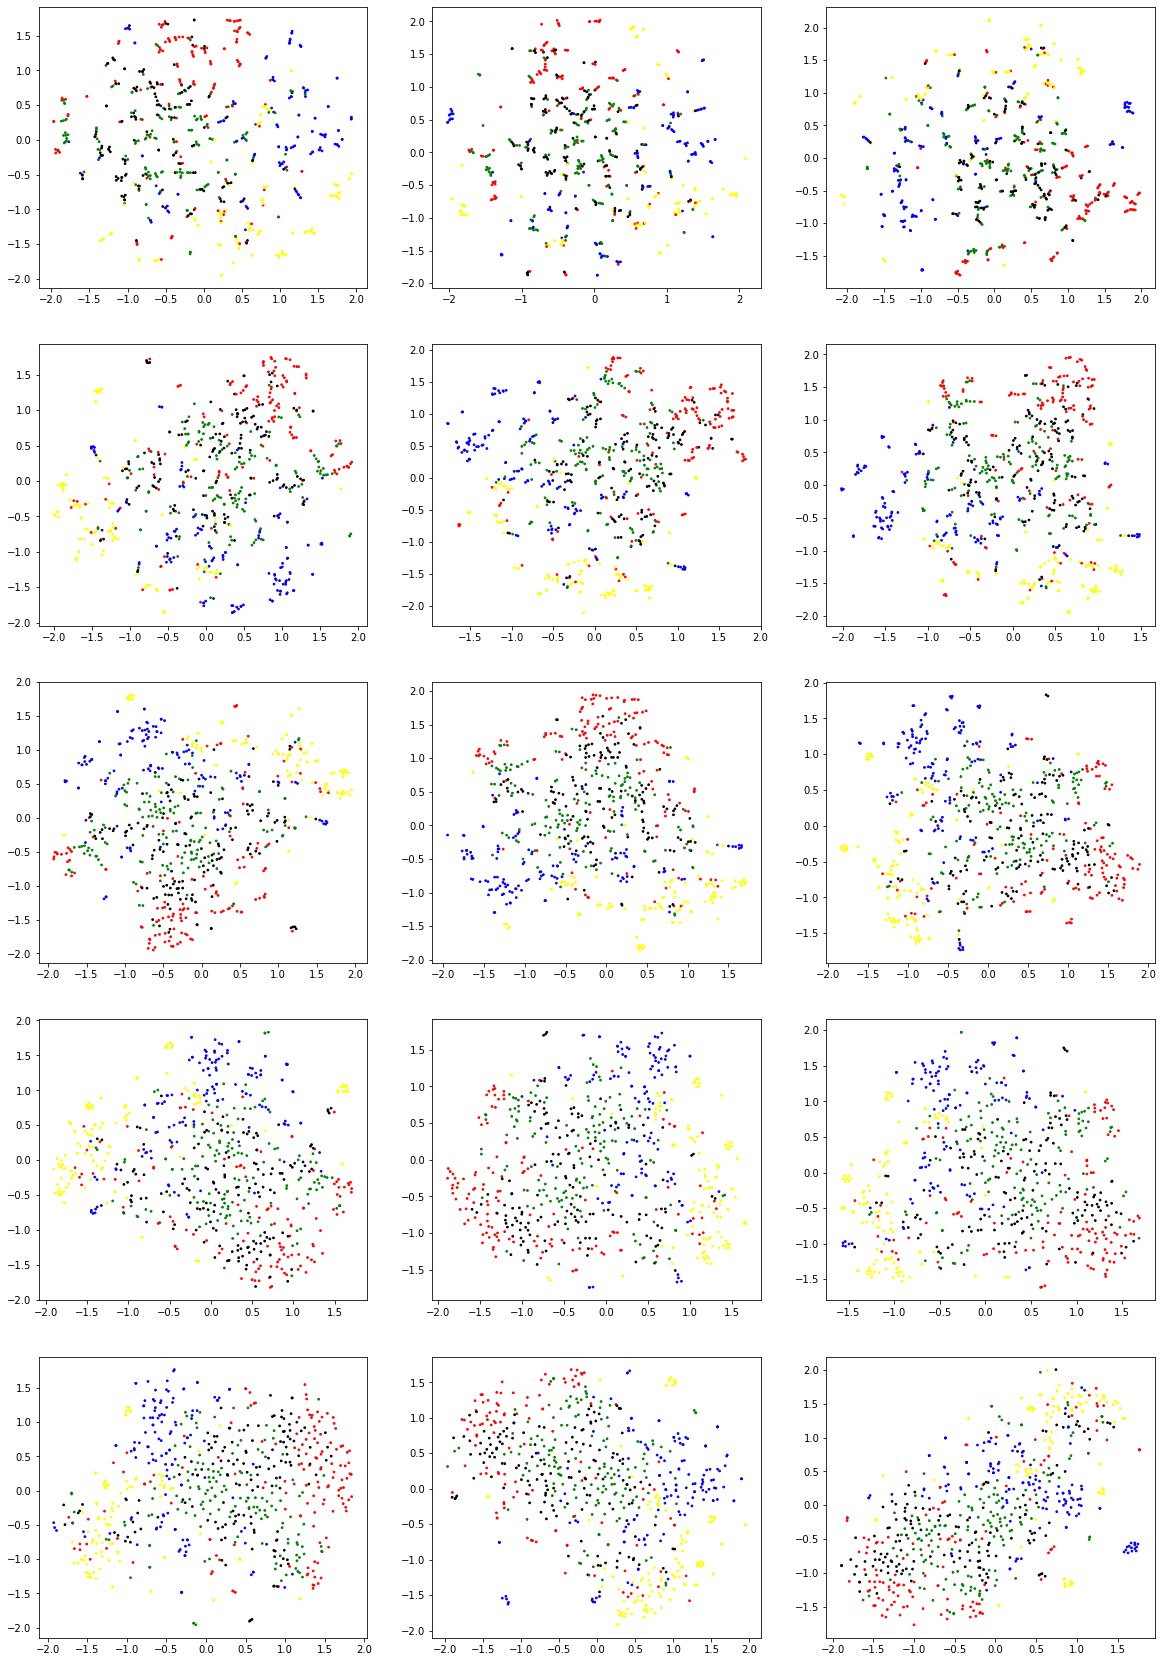

In [0]:
# Test T-SNE
if test_tsne:
  perplexities = [2, 5, 10, 20, 40]
  iterations = [1000, 2000, 4000]

  results = []
  for perplexity in perplexities:
    for iteration in iterations:

        print("Calculating with parameters:", perplexity, iteration)
        embedding = TSNE(n_components=2,
                      perplexity=perplexity,
                      n_iter=iteration).fit_transform(features)
        scaler = StandardScaler()
        scaler.fit(embedding)
        data = scaler.transform(embedding)

        results.append({
            'data': data,
            'params': [perplexity, iteration]
        })

  plot_all(results, labels)

Calculating with parameters: 3
Calculating with parameters: 5
Calculating with parameters: 10
Calculating with parameters: 15
Calculating with parameters: 30


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


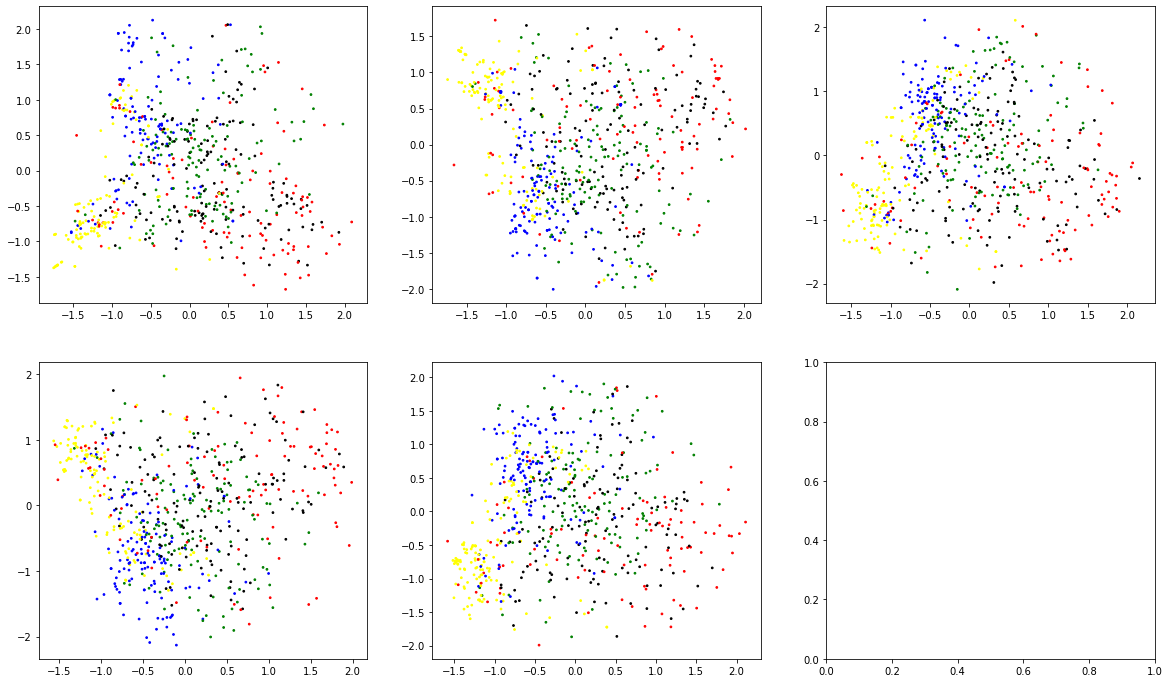

In [0]:
# Test Isomap
if test_isomap:
  n_neighbors = [3, 5, 10, 15, 30]

  results = []
  for n_neighbor in n_neighbors:

    print("Calculating with parameters:", n_neighbor)
    embedding = Isomap(n_components=2,
                      n_neighbors=n_neighbor).fit_transform(features)
    scaler = StandardScaler()
    scaler.fit(embedding)
    data = scaler.transform(embedding)
    
    results.append({
        'data': data,
        'params': [n_neighbor]
    })

  plot_all(results, labels)

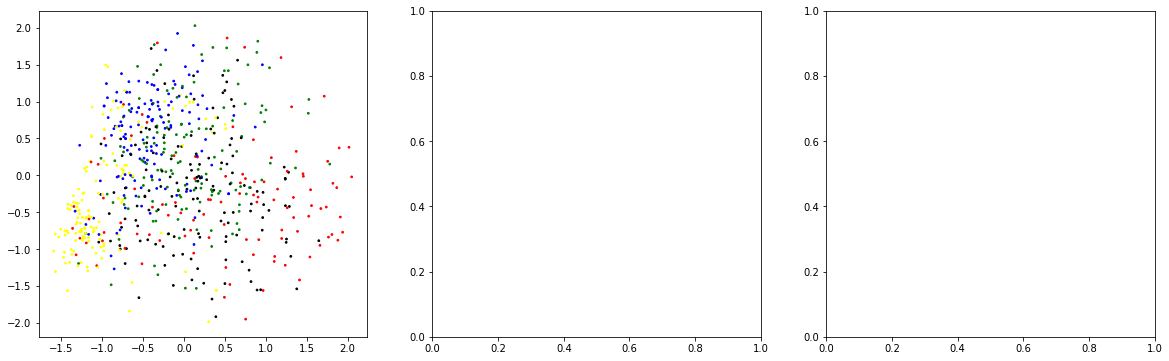

In [0]:
# Test PCA
if test_pca:

  embedding = PCA(n_components=2).fit_transform(features)

  scaler = StandardScaler()
  scaler.fit(embedding)
  data = scaler.transform(embedding)

  results = []
  results.append({
      'data': data,
      'params': [[]]
  })

  plot_all(results, labels)

Sigma: 1
Neighborhood function: gaussian
 [ 4000 / 4000 ] 100% - 0:00:00 left 
 quantization error: 0.2299456307627809
 topographic error: 0.05733333333333333


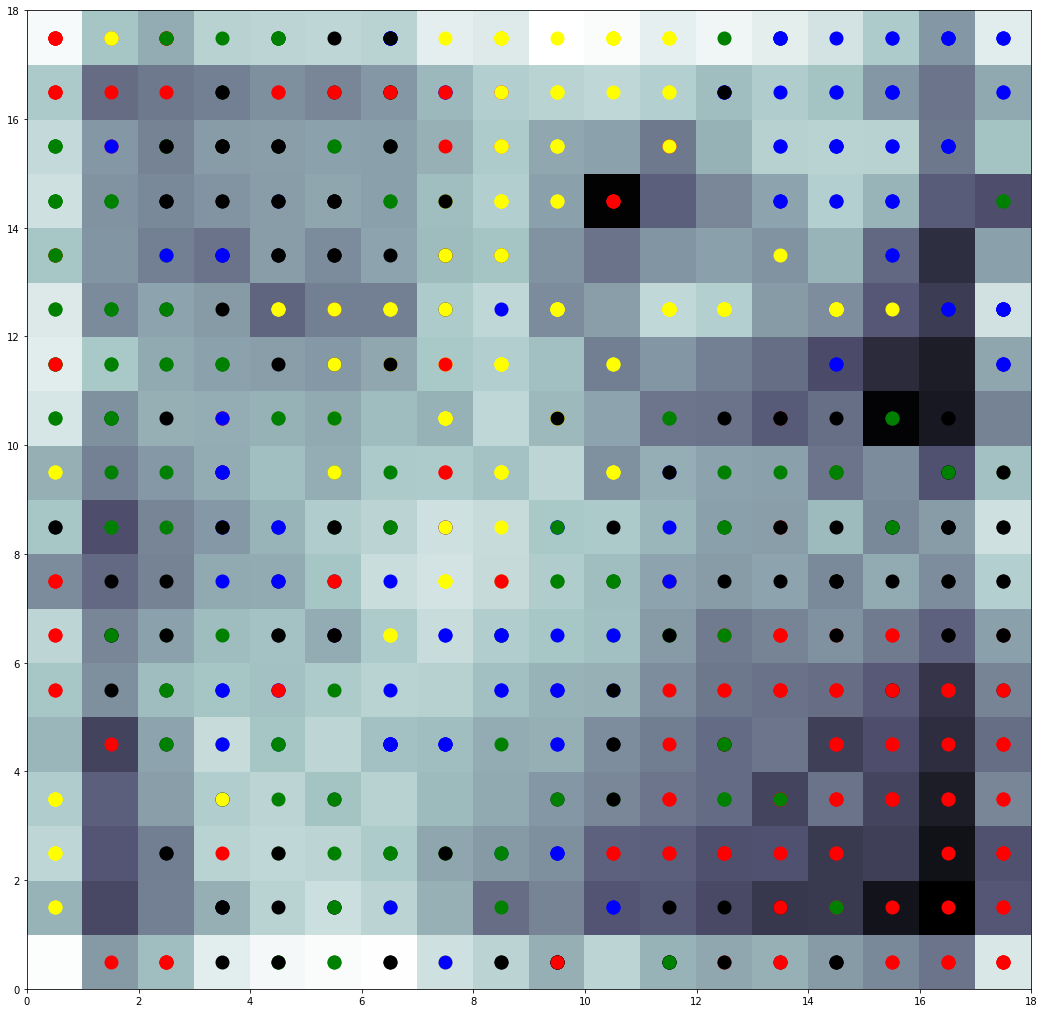

Sigma: 1
Neighborhood function: triangle
 [ 4000 / 4000 ] 100% - 0:00:00 left 
 quantization error: 0.3185164236994697
 topographic error: 0.9253333333333333


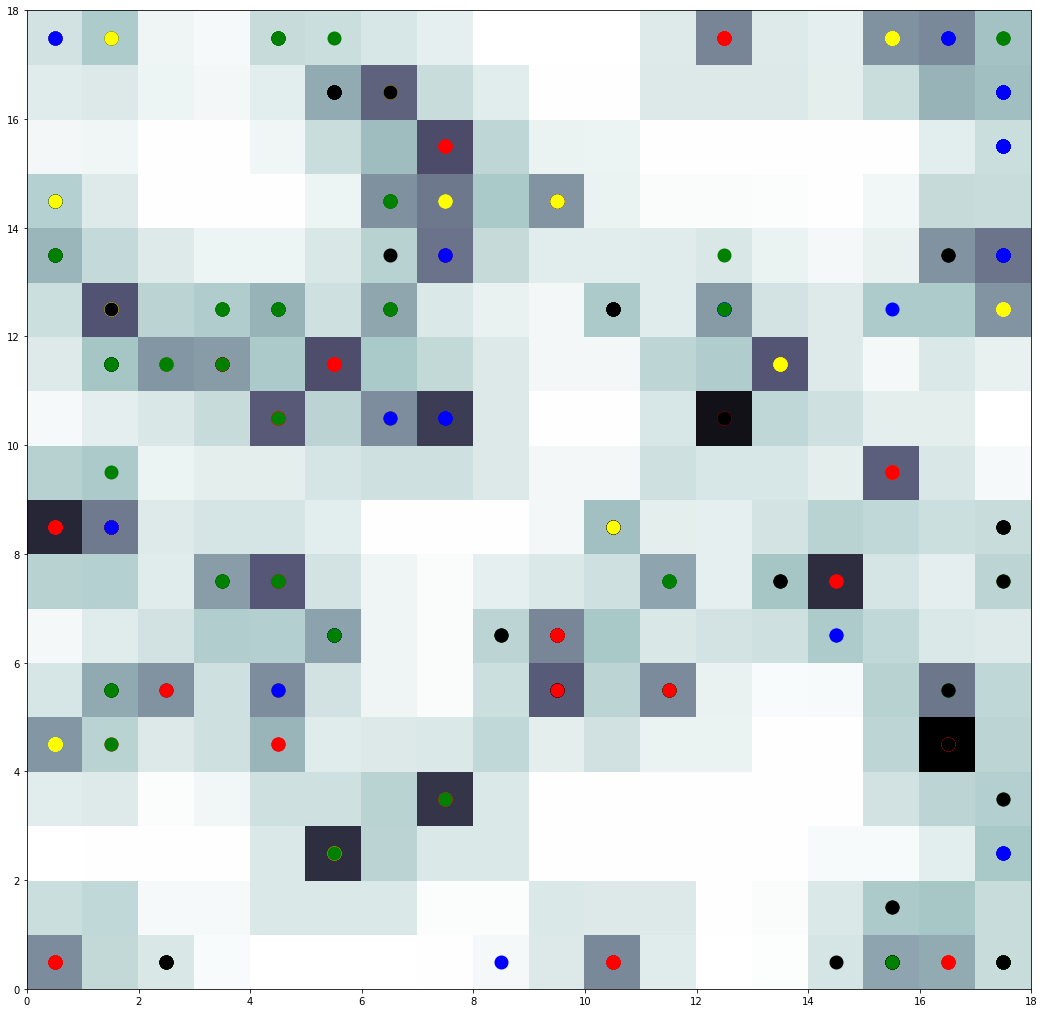

Sigma: 4
Neighborhood function: gaussian
 [ 4000 / 4000 ] 100% - 0:00:00 left 
 quantization error: 0.4574345630327011
 topographic error: 0.024


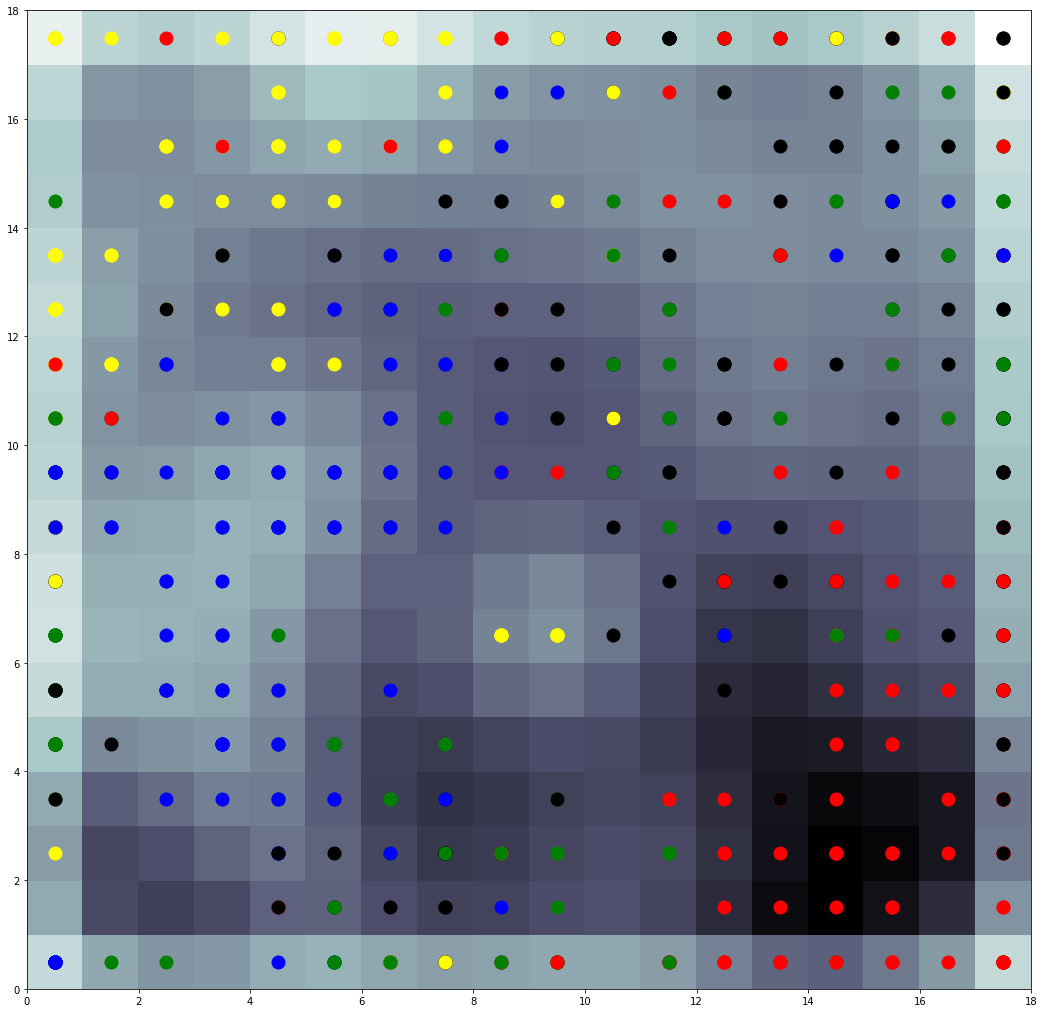

Sigma: 4
Neighborhood function: triangle
 [ 4000 / 4000 ] 100% - 0:00:00 left 
 quantization error: 0.20202105734821887
 topographic error: 0.12933333333333333


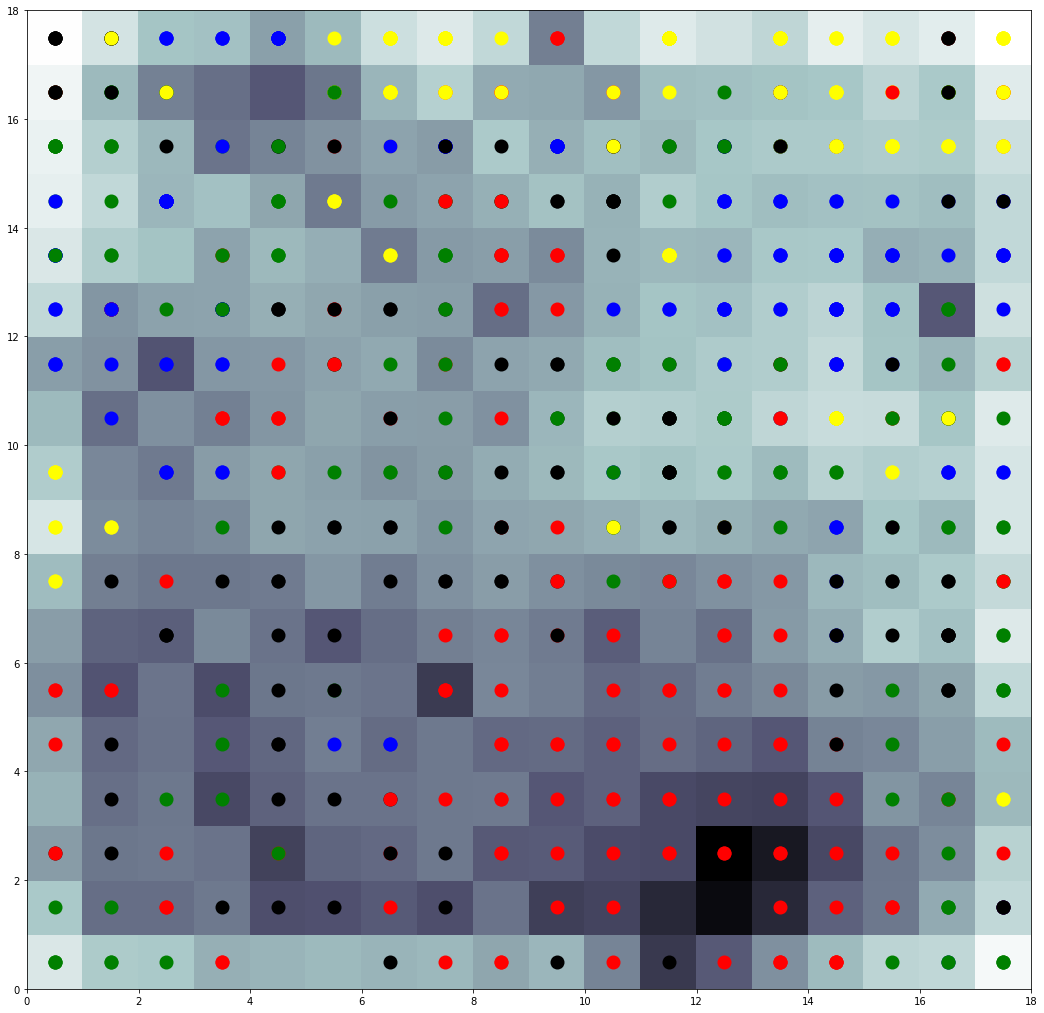

Sigma: 6
Neighborhood function: gaussian
 [ 4000 / 4000 ] 100% - 0:00:00 left 
 quantization error: 0.5375524869381955
 topographic error: 0.013333333333333334


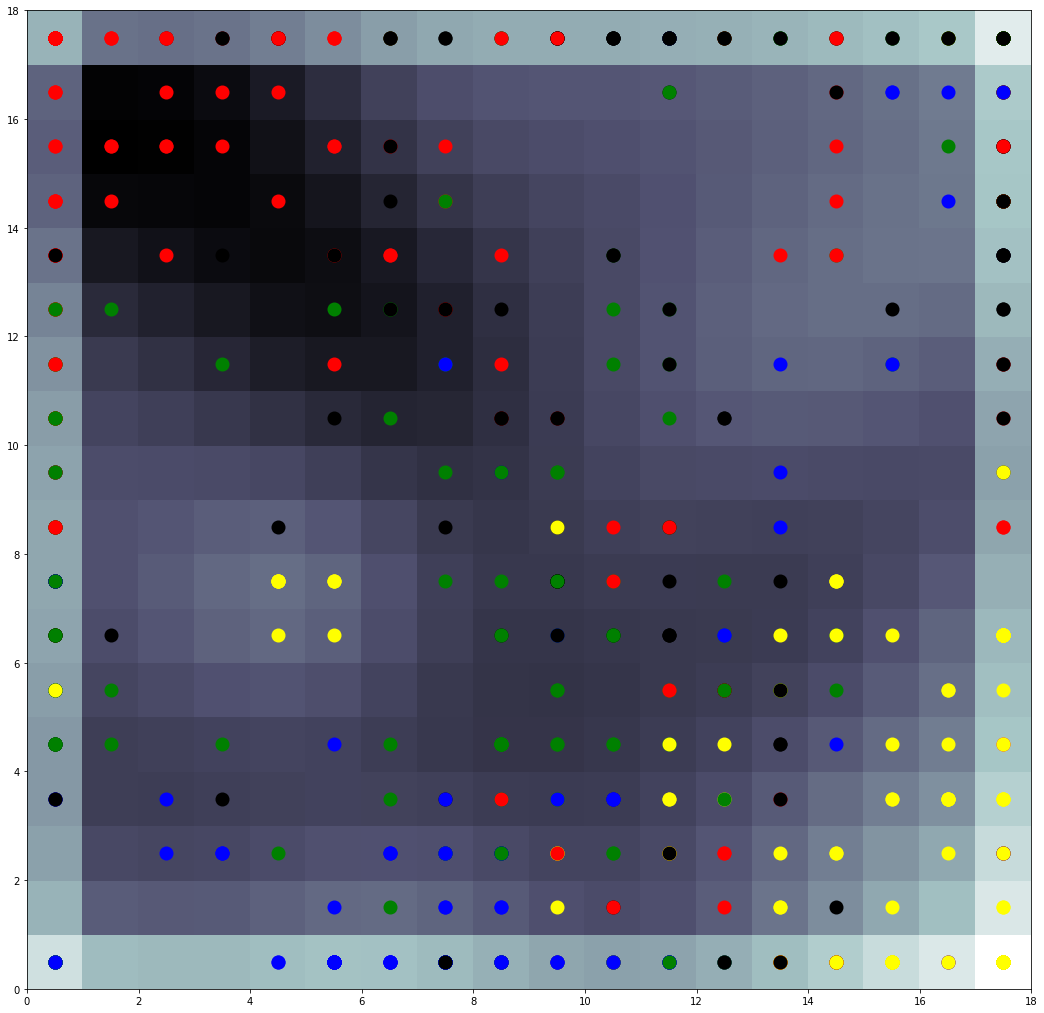

Sigma: 6
Neighborhood function: triangle
 [ 4000 / 4000 ] 100% - 0:00:00 left 
 quantization error: 0.326846412853071
 topographic error: 0.24133333333333334


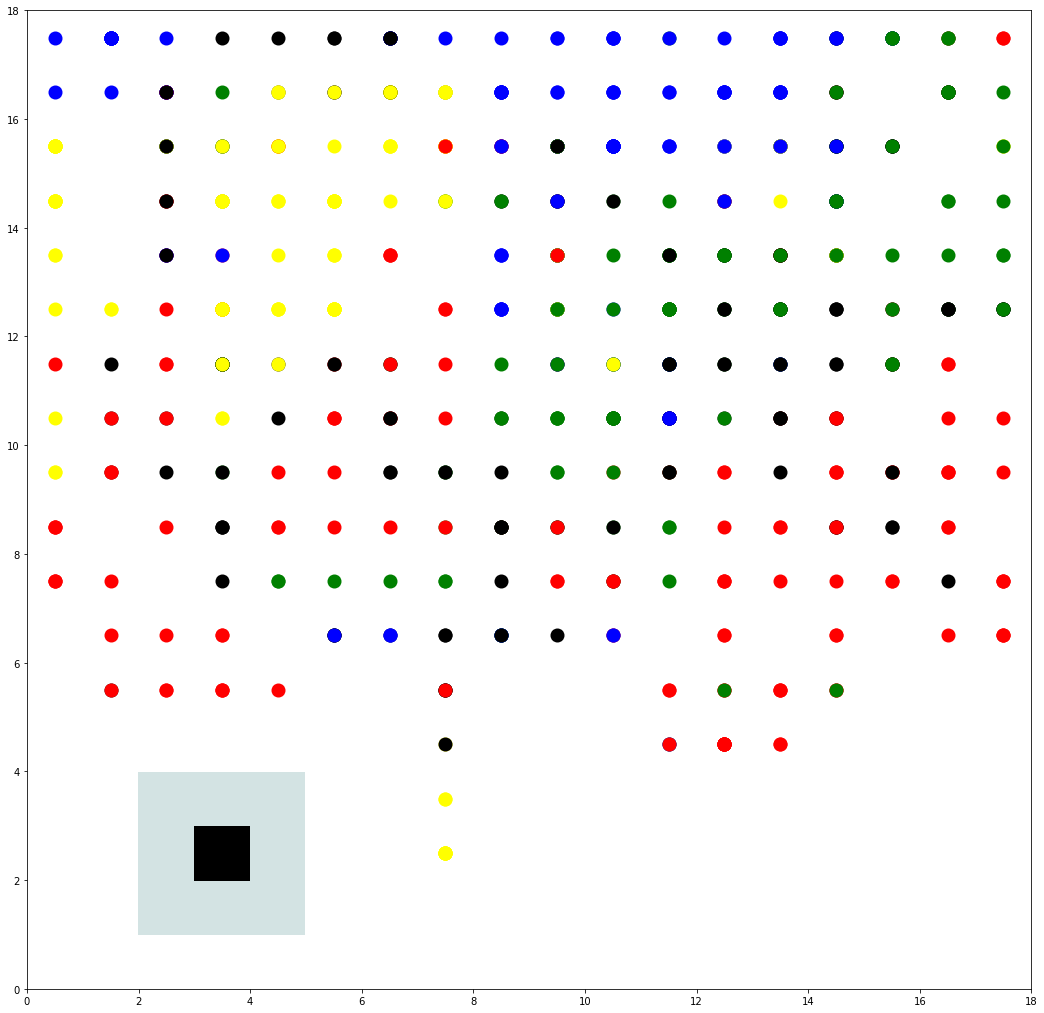

In [0]:
# Test SOM
if test_som:
  x = 18
  y = 18

  sigmas = [1, 4, 6]
  neighb_fs = ['gaussian', 'triangle']

  for sigma in sigmas:
    for neighborhood_function in neighb_fs:

      print("Sigma:", sigma)
      print("Neighborhood function:", neighborhood_function)

      som = MiniSom(x, y, input_len=features.shape[1], sigma=sigma, learning_rate=0.5, 
                    neighborhood_function=neighborhood_function, random_seed=10)

      som.pca_weights_init(features)

      som.train_batch(features, 4000, verbose=True)  # random training

      plt.figure(figsize=(x, y))
      # Plotting the response for each pattern in the iris dataset
      plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
      #plt.colorbar()


      # use different colors and markers for each label
      colors = np.array(['blue', 'red', 'green', 'black', 'yellow'])

      for cnt, xx in enumerate(features):
          w = som.winner(xx)  # getting the winner
          # palce a marker on the winning position for the sample xx
          plt.plot(w[0]+.5, w[1]+.5, marker='o', markeredgecolor=colors[labels[cnt]],
                  markerfacecolor=colors[labels[cnt]], markersize=12, markeredgewidth=2)
      plt.axis([0, x, 0, y])
      plt.show()

In [0]:
# Calculate optimal TSNE
embedding = TSNE(n_components=2,
              perplexity=40,
              n_iter=2000).fit_transform(features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(embedding, labels, 
                                                    test_size=0.2, random_state=17, shuffle=True)
# Test KNN classifier on T-SNE embedding
n_neighbors = int(0.5*150)
neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(X_train, y_train)

# Evaluate
score = neigh.score(X_test, y_test)
print(score)

0.5666666666666667
